In [1]:
import matplotlib.pyplot as plt
import random as r
import pprint as pp
import numpy as np
import csv

In [2]:
# Define type of slice and its parameters
slices_type = {
    'eMBB' : {
        'bandwidth_max': 100000000, #max bandwidth which BS can give to this slice
        'client_weight': 0.3, # Portion of clients which use this type of slice
        'band_guaranteed' : 0, # based on quality of service
        'min': 4000000, 
        'max': 800000000 # how much bps can require this type of slice
      },
      'URLLC' : {
        'bandwidth_max': 10000000,
        'client_weight': 0.2,
        'band_guaranteed' : 5000000,
        'min': 800,
        'max': 8000000
      },
      'MIoT' : {
        'bandwidth_max': 10000000,
        'client_weight': 0.15,
        'band_guaranteed' : 1000000,
        'min': 800000, 
        'max': 8000000
      },
      'mMTC' : {
        'bandwidth_max': 10000000,
        'client_weight': 0.15,
        'band_guaranteed' : 1000000,
        'min': 800000, 
        'max': 8000000
      },
      'voice' : {
        'bandwidth_max': 1000000,
        'client_weight': 0.2,
        'band_guaranteed' : 500000,
        'min': 4000000, 
        'max': 8000000
     }
}
          
# Define base station parameters
basestation = {
    'capacity': 20000000000,   #20Gbps
    'coverage': 250,
    'ratios': { # portion of capacity dedicated to various slice type
        'URLLC': 0.05,
        'eMBB': 0.65,
        'mMTC': 0.1,
        'voice': 0.1,
        'MIoT': 0.1
    },
    'x': 300,
    'y': 300
}

# Define mobility patterns and its parameters
mobility_patterns = {
  'car': {
    'distribution': 'normal',
    'params':(0,7),
    'client_weight': 0.10
  },
  'walk': {
    'distribution': 'randint',
    'params': (-1, 1),
    'client_weight': 0.40
  },
  'stationary': {
    'distribution': 'normal',
    'params': (0, 0.1),
    'client_weight': 0.20
  },
  'publictransport': {
    'distribution': 'randint',
    'params': (-4, 4),
    'client_weight': 0.10
  },
  'slackperson':{
    'distribution': 'randint',
    'params':(0, 1),
    'client_weight': 0.20
  }
}

In [3]:
# Define obj Client
class Client:
    def __init__(self, ID, x, y, mobility_pattern, freq, slice_type, slice_cap, bs):
        self.ID = ID
        self.x = x
        self.y = y
        self.mobility_pattern = mobility_pattern
        self.freq = freq
        self.slice_type = slice_type
        self.bs = bs
        self.slice_cap = slice_cap
        self.usage_rem = 0
        self.last_usage = 0
        self.connected = False
        
        # stats
        self.tot_connected_time = 0
        self.tot_unconnected_time = 0
        self.tot_requests = 0
        self.consume_time = 0
        self.tot_usage = 0
        
     # for each user we do 4 steps, at each iteration:
     # 1  Connection to BS and start consume
     # 2  Release consume
     # 3  Continue client movement
     
    def step_1(self):
        if self.bs is not None:
            if self.usage_rem > 0:
                if self.connected:
                    self.start_consume()
                else:
                    self.connect()
            else:
                if self.connected:
                    self.disconnect()
                else:
                    self.generate_usage_and_connect()
        
    def step_2(self):
        if self.connected and self.last_usage > 0:
            self.release_consume()
            if self.usage_rem == 0:
                self.disconnect()
    
    def step_3(self):
        x, y = self.move()
        self.x += x
        self.y += y
        if self.bs is not None:
            if not inRange(self, bs):
                self.disconnect()       
                
    def generate_usage_and_connect(self):
        if self.slice_type is not None:
            # Generate new usage
            self.usage_rem = self.generate()
            self.tot_requests += 1
            self.connect()
            #print(f"Client_{self.ID}, coordinates : ({self.x}, {self.y}) requests {self.usage_rem} usage to BS{self.bs.ID}")     

    def connect(self):
        s = self.slice_type
        if self.connected:
            return
        if self.is_avaliable():         # threshold for usage
            self.connected = True
            bs.connected_users += 1
            #print(f"Client {self.ID}, coordinates : ({self.x}, {self.y}) connected to slice {s} @ BS{self.bs.ID}")
            return True
        else:
            self.connected = False
            #print(f"Client {self.ID}, coordinates : ({self.x}, {self.y}) connection refused to slice {s} @ BS{self.bs.ID}")
            return False
        
    def disconnect(self):
        if self.connected == True:
            bs.connected_users -= 1
            self.connected = False
        #print(f"Client {self.ID}, coordinates: ({self.x},{self.y}) disconnected from slice {self.slice_type} @ BS{self.bs.ID} ")
        return not self.connected
    
    def start_consume(self):
        amount = min(self.usage_rem, self.get_consumable_share())    # bandwidth allocation
        bs.band_remaining -= amount  # BS allocate bandwidth and its capacity decreases
        bs.pot_band_remaining -= amount
        self.last_usage = amount
        #print(f"Client {self.ID}, coordinates: ({self.x}, {self.y}) gets {amount} usage from @ BS{self.bs.ID}")
           
    def release_consume(self):
        # release resources
        if self.last_usage > 0:
            bs.band_remaining += self.last_usage
            self.consume_time += 1
            self.tot_usage += self.last_usage
            self.usage_rem -= self.last_usage
            #print(f"Client {self.ID}, coordinates: ({self.x}, {self.y}), releases {self.last_usage} usage to BS{self.bs.ID}")
            self.last_usage = 0
        
    # update client coordinates (TODO)    
    def move(self):   
        distr = self.mobility_pattern.distribution
        params = self.mobility_pattern.params
        if distr == "randint":
            delta_x = r.randint(params[0], params[1])
            delta_y = r.randint(params[0], params[1])
            return delta_x, delta_y
        if distr == "normal":
            delta_x = np.random.normal(params[0], params[1])
            delta_y = np.random.normal(params[0], params[1])
            return delta_x, delta_y 
        
    # generate client consume   
    def generate(self):
        s = self.slice_type
        amount = r.randint(slices_type[s]['min'], slices_type[s]['max'])
        return amount
    
    def is_avaliable(self):
        global client_per_slice
        s = self.slice_type
        bandwidth_next = self.slice_cap / (client_per_slice[s] + 1)
        if bandwidth_next < slices_type[s]['band_guaranteed']:
            return False
        return True
      
    def get_consumable_share(self):
        global client_per_slice
        s = self.slice_type

        if client_per_slice.get(s) <= 0:
            return int(min(self.slice_cap, slices_type[s]['bandwidth_max'] ))
        else:
            return int(min(self.slice_cap/client_per_slice[s], slices_type[s]['bandwidth_max'] ))
            

In [4]:
# Define obj Mobility 
class Mobility:
    def __init__(self, name, distribution, params):
        self.name = name
        self.distribution = distribution
        self.params = params

In [5]:
# Define obj BaseStation
class BaseStation:
    def __init__(self,ID, x, y, coverage, capacity, ratios):
        self.ID =ID
        self.x = x
        self.y = y
        self.coverage = coverage
        self.capacity = capacity
        self.ratios = ratios
        self.pot_band_remaining = capacity
        self.band_remaining = capacity
        self.connected_users = 0

In [6]:
def get_random_mobility_pattern(vals, mobility_patterns):
    i = 0
    j = r.random()

    while vals[i] < j:
        i += 1

    return mobility_patterns[i]


def get_random_slice_type(vals):
    i = 0
    j = r.random()
    s = ''

    while vals[i] < j:
        i += 1
    
    if i == 0:
       s = 'eMBB'
    if i == 1:
       s = 'URLLC' 
    if i == 2:
       s = 'MIoT' 
    if i == 3:
       s = 'mMTC' 
    if i == 4:
       s = 'voice' 
    
    return s

def get_number_user_slice_type(all_client):
    embb = 0
    miot = 0
    mmtc = 0
    voice = 0 
    urllc = 0
    
    for c in all_client:
        if c.slice_type == 'eMBB':
            embb = embb + 1

        if c.slice_type == 'URLLC':
            urllc = urllc + 1

        if c.slice_type == 'MIoT':
            miot = miot + 1

        if c.slice_type == 'mMTC':
            mmtc = mmtc + 1

        if c.slice_type == 'voice':
            voice = voice + 1
    
    user_per_slice = {'eMBB': embb,
                      'URLLC': urllc,
                      'MIoT': miot,
                      'mMTC': mmtc,
                      'voice': voice
                     }
    
    return user_per_slice
        

def inRange(client, bs):
    x_client = client.x
    y_client = client.y
    x_bs = bs.x
    y_bs = bs.y
    if (abs(x_client - x_bs) < bs.coverage) and (abs(y_client - y_bs) < bs.coverage):
        return True
        print('true')
    else:
        return False
        print('false')

collected, slice_weights = 0, []
for key, value in slices_type.items():
    collected += value['client_weight']
    slice_weights.append(collected)

collected, mb_weights = 0, []
for key, value in mobility_patterns.items():
    collected += value['client_weight']
    mb_weights.append(collected)
    
m_patterns = []
for name, mb in mobility_patterns.items():
    mobility_pattern = Mobility(name, mb['distribution'], mb['params'])
    m_patterns.append(mobility_pattern)    

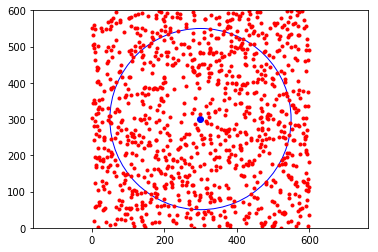

In [7]:
# Round 0: create network area, place base station and clients
num_clients = 1000
simulation_time = 40
x_area = 600
y_area = 600

bs = BaseStation(0, basestation.get('x'), basestation.get('y'), basestation.get('coverage'), basestation.get('capacity'), basestation.get('ratios'))

clients = []
for i in range(num_clients):
    x = r.randint(0, x_area)
    y = r.randint(0, y_area)
    freq = r.random()
    
    mobility_pattern = get_random_mobility_pattern(mb_weights, m_patterns)
    slice_type = get_random_slice_type(slice_weights) 
    slice_capacity = bs.ratios.get(slice_type) * bs.capacity
    
    c = Client(i, x, y, mobility_pattern, freq, slice_type, slice_capacity, bs)
    clients.append(c)

ax = plt.gca()
plt.axis('equal')
ax.set_xlim(0, x_area)
ax.set_ylim(0, y_area)
ax.plot(bs.x, bs.y, 'o', color='blue')
circle = plt.Circle((bs.x,bs.y), radius = bs.coverage, fill=False, color='blue')
ax.add_artist(circle)
    
for i in range(num_clients):
    ax.plot(clients[i].x, clients[i].y,'.',color='red')

In [8]:
# Define class Request
class Request:
    def __init__(self, id_client, type_slice, traffic_request, traffic_left):
        self.id_client = id_client
        self.type_slice = type_slice
        self.traffic_request = traffic_request
        self.traffic_left = traffic_left
        
#Define class csv
class CsvData:
    def __init__(self, step, r_embb, g_embb, connect_embb, r_urllc, g_urllc, connect_urllc, r_miot, g_miot, connect_miot, r_mmtc, g_mmtc, connect_mmtc, r_voice, g_voice, connect_voice):
        self.step = step
        self.r_embb = r_embb
        self.g_embb = g_embb
        self.connect_embb = connect_embb
        self.r_urllc = r_urllc
        self.g_urllc = g_urllc
        self.connect_urllc = connect_urllc
        self.r_miot = r_miot
        self.g_miot = g_miot
        self.connect_miot = connect_miot
        self.r_mmtc = r_mmtc
        self.g_mmtc = g_mmtc
        self.connect_mmtc = connect_mmtc
        self.r_voice = r_voice
        self.g_voice = g_voice
        self.connect_voice = connect_voice

In [9]:
clients_inRange = []

for i in range(num_clients):
    if inRange(clients[i], bs):
        clients_inRange.append(clients[i])

# create fixed size list to manage the request
request_list = [None] * len(clients)
active_clients = []
csv_final = []

for n in range(simulation_time):
    
    # manage number active clients
    active = []
    new_connection = r.randint(0, len(clients_inRange))
    active = r.sample(clients_inRange, new_connection)
    
    for j in range(len(active)):
        if request_list[active[j].ID] == None:
            active_clients.append(active[j])
            
    client_per_slice = get_number_user_slice_type(active_clients)
    
    print('STEP', n)
    
    for i in range(len(active_clients)):   
        # step 1 and create request
        active_clients[i].step_1()
        
        req = Request(active_clients[i].ID, active_clients[i].slice_type, active_clients[i].usage_rem, active_clients[i].usage_rem)
        request_list[active_clients[i].ID] = req
    
    for i in range(len(active_clients)):
        # step 2 and update request (delete non active user, and update traffic)
        active_clients[i].step_2()
        request_list[active_clients[i].ID].traffic_left = active_clients[i].usage_rem
    
    user_embb, user_urllc, user_miot, user_mmtc, user_voice = 0, 0, 0, 0, 0
    req_embb, req_urllc, req_miot, req_mmtc, req_voice = 0, 0, 0, 0, 0
    giv_embb, giv_urllc, giv_miot, giv_mmtc, giv_voice = 0, 0, 0, 0, 0
    for item in request_list:
     if item is not None:
        if item.type_slice == 'eMBB':
            if item.traffic_request - item.traffic_left != 0:
                req_embb += item.traffic_request
                giv_embb += item.traffic_request - item.traffic_left
                user_embb += 1   
            else:
                req_embb += 0
                giv_embb += 0
                user_embb += 1   
        if item.type_slice == 'URLLC' :
            if item.traffic_request - item.traffic_left != 0:
                req_urllc += item.traffic_request
                giv_urllc += item.traffic_request - item.traffic_left
                user_urllc += 1
            else:
                req_urllc += 0
                giv_urllc += 0
                user_urllc += 1   
        if item.type_slice == 'MIoT':
            if item.traffic_request - item.traffic_left != 0:
                req_miot += item.traffic_request
                giv_miot += item.traffic_request - item.traffic_left
                user_miot += 1
            else:
                req_miot += 0
                giv_miot += 0
                user_miot += 1   
        if item.type_slice == 'mMTC':
            if item.traffic_request - item.traffic_left != 0:
                req_mmtc += item.traffic_request
                giv_mmtc += item.traffic_request - item.traffic_left
                user_mmtc += 1
            else:
                req_mmtc += 0
                giv_mmtc += 0
                user_mmtc += 1   
        if item.type_slice == 'voice':
            if item.traffic_request - item.traffic_left != 0:
                req_voice += item.traffic_request
                giv_voice += item.traffic_request - item.traffic_left
                user_voice += 1   
            else:
                req_voice += 0
                giv_voice += 0
                user_voice += 1 
           
    csv_data = CsvData(n, req_embb, giv_embb, user_embb, req_urllc, giv_urllc, user_urllc, req_miot, giv_miot, user_miot, req_mmtc, giv_mmtc, user_mmtc, req_voice, giv_voice, user_voice)  
    csv_final.append(csv_data)
    
    for i in range(len(active_clients)):
        if active_clients[i].connected == False:
            request_list[active_clients[i].ID] = None

    for item in active_clients:
        # step 3 and delete also user not in range
        item.step_3()
        if item.connected == False:
            request_list[item.ID] = None
            active_clients.remove(item)
    

STEP 0
STEP 1
STEP 2
STEP 3
STEP 4
STEP 5
STEP 6
STEP 7
STEP 8
STEP 9
STEP 10
STEP 11
STEP 12
STEP 13
STEP 14
STEP 15
STEP 16
STEP 17
STEP 18
STEP 19
STEP 20
STEP 21
STEP 22
STEP 23
STEP 24
STEP 25
STEP 26
STEP 27
STEP 28
STEP 29
STEP 30
STEP 31
STEP 32
STEP 33
STEP 34
STEP 35
STEP 36
STEP 37
STEP 38
STEP 39


In [10]:
with open('input.csv', mode='w') as csv_file:
    fieldnames = ['embb_rate', 'embb_users', 'embb_req', 'urllc_rate', 'urllc_users', 'urllc_req', 'miot_rate', 'miot_users', 'miot_req', 'mmtc_rate', 'mmtc_users', 'mmtc_req', 'voice_rate', 'voice_users', 'voice_req']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    
    writer.writeheader()
    for item in csv_final:
        writer.writerow({'embb_rate': item.g_embb, 'embb_users': item.connect_embb, 'embb_req': item.r_embb, 'urllc_rate': item.g_urllc, 'urllc_users': item.connect_urllc, 'urllc_req': item.r_urllc, 'miot_rate': item.g_miot, 'miot_users': item.connect_miot, 'miot_req': item.r_miot, 'mmtc_rate': item.g_mmtc, 'mmtc_users': item.connect_mmtc, 'mmtc_req': item.r_mmtc, 'voice_rate': item.g_voice, 'voice_users': item.connect_voice, 'voice_req': item.r_voice,})
    